# **Integrated Gradients & DenseNet-121: Explainability Analysis**

## **Imports**

In [ ]:
import os
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage import exposure
from skimage.metrics import structural_similarity as ssim
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, erosion, dilation, disk
from sklearn.linear_model import LogisticRegression

## **Integrated Gradients Implementation**
### **1. Loading the DenseNet-121 Model**
- A **pretrained DenseNet-121** model is loaded via `torchvision`.
- Set to **evaluation mode (`eval()`)** for stable inference.
- DenseNet-121 is chosen for its **dense connectivity**, improving feature reuse and gradient propagation.

### **2. Preprocessing Input Images**
- `preprocess_image(image_path)`:
  - Loads an image and converts it to **RGB**.
  - **Resizes** to **224×224 pixels** (required input size for DenseNet-121).
  - **Normalizes** using ImageNet’s standard mean **(μ = [0.485, 0.456, 0.406])** and standard deviation **(σ = [0.229, 0.224, 0.225])**.
  - Converts the image to a **PyTorch tensor** and adds a batch dimension.

### **3. Computing Integrated Gradients (IG)**
- Integrated Gradients (IG) is a feature attribution method that computes pixel-level importance scores by integrating gradients along a straight-line path from a baseline image x' to the actual input x :

$$ IG_i(x) = (x_i - x_i') \times \int_{\alpha=0}^{1} \frac{\partial f(x' + \alpha (x - x'))}{\partial x_i} d\alpha $$

- `integrated_gradients()`:
  - Uses a **black baseline** \( x' = 0 \).
  - **Interpolates** between the baseline and input image across **N=200** steps:

$$
x^{(\alpha)} = x' + \alpha (x - x')
$$

  - Computes **gradients**  $$  \nabla f(x^{(\alpha)})  $$ with respect to the predicted class.
  - Approximates the integral using the Riemann sum:

$$
IG_i(x) \approx (x_i - x_i') \times \sum_{k=1}^{N} \frac{\partial f(x' + \frac{k}{N} (x - x'))}{\partial x_i} \times \frac{1}{N}
$$

  - **Averages gradients** over interpolation steps.
  - **Multiplies averaged gradients** by the input difference to obtain attributions.
  - Applies **Gaussian filtering (σ=2)** to reduce noise.
  - Enhances contrast with **Adaptive Histogram Equalization**.
  - **Normalizes** attributions to **[0,1]** for visualization.

### **4. Overlaying Heatmaps**
- `overlay_heatmap()`:
  - Uses **OpenCV TURBO colormap** to enhance visualization.
  - **Blends the heatmap** with the original image, applying transparency **(alpha = 0.4)**.

### **5. Visualizing IG Results**
- `visualize_integrated_gradients()`:
  - Preprocesses the image and runs it through the model.
  - Retrieves the **predicted class**.
  - Computes **IG attributions**.
  - Displays:
    1. **Original Image**
    2. **IG Heatmap** (highlighting influential pixels).
    3. **Overlayed Heatmap** (for better interpretability).
  - Uses **matplotlib** for visualization.

### **6. Running the Pipeline**
- The function is applied to an example image (`TP2_images/2637374064_fab14ec0b8.jpg`).
- Generates **an attribution map** indicating the most influential pixels for the model’s decision.


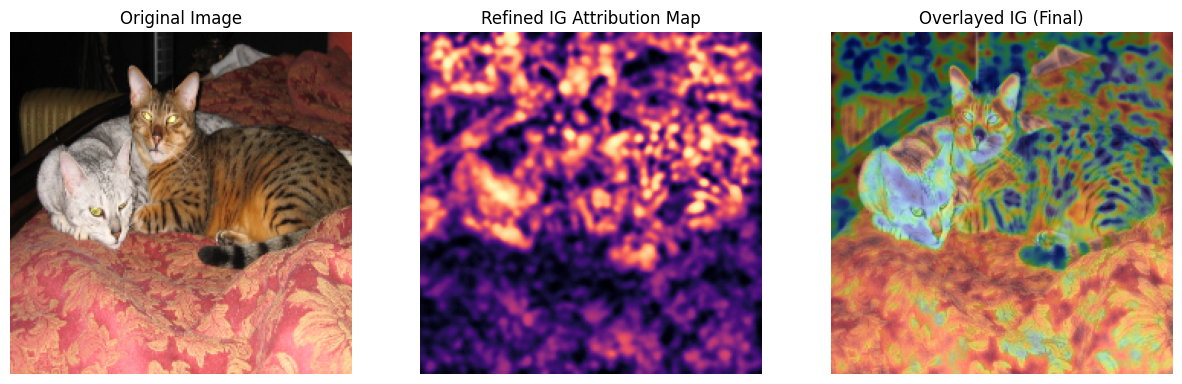

In [ ]:
# Load DenseNet-121 Model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.eval()

def preprocess_image(image_path):
    """Loads and preprocesses an image for DenseNet-121."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def integrated_gradients(model, image, target_class, baseline=None, steps=200):  # Reduced steps
    """Computes Improved Integrated Gradients (IG) attributions."""
    if baseline is None:
        baseline = torch.zeros_like(image)  # Black baseline (more stable)

    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(image.device)
    interpolated_images = baseline + alphas * (image - baseline)
    interpolated_images.requires_grad_()

    output = model(interpolated_images)
    loss = output[:, target_class].sum()

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated_images, retain_graph=True)[0]
    avg_gradients = gradients.mean(dim=0)

    # Compute IG attributions
    attributions = (image - baseline) * avg_gradients
    attributions = attributions.squeeze().detach().cpu().numpy().sum(axis=0)

    # Smoother Gradient Filtering
    attributions = gaussian_filter(np.abs(attributions), sigma=2)

    # Adaptive Histogram Equalization
    attributions = exposure.equalize_adapthist(attributions, clip_limit=0.02)

    # Normalize to [0, 1]
    attributions = attributions / (attributions.max() + 1e-8)

    return attributions

def overlay_heatmap(image, attributions, alpha=0.4):
    """Overlays IG heatmap on original image with improved contrast."""
    heatmap = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_TURBO)
    heatmap = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return heatmap

def visualize_integrated_gradients(image_path, model):
    """Runs IG on an image and visualizes the results."""
    try:
        image_tensor = preprocess_image(image_path)
        orig_image = cv2.imread(image_path)
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        orig_image = cv2.resize(orig_image, (224, 224))

        output = model(image_tensor)
        predicted_class = torch.argmax(output).item()
        attributions = integrated_gradients(model, image_tensor, predicted_class, steps=200)  

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(attributions, cmap="magma")
        ax[1].set_title("Refined IG Attribution Map")
        ax[1].axis("off")

        overlayed_image = overlay_heatmap(orig_image, attributions)
        ax[2].imshow(overlayed_image)
        ax[2].set_title("Overlayed IG (Final)")
        ax[2].axis("off")

        plt.show()
    
    except FileNotFoundError as e:
        print(f" Error: {e}")

# Run on the image
image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
visualize_integrated_gradients(image_path, model)



## **Evaluation Metrics Overview**
### **1. Robustness Check**
- `compute_robustness()`:
  - Adds Gaussian noise to attributions.
  - Smooths with a Gaussian filter.
  - Measures correlation with original attributions (higher = more robust).

### **2. Faithfulness Assessment**
- **Deletion Test (`faithfulness_deletion()`)**
  - Removes the top 10% most important pixels.
  - Measures confidence drop (larger drop = higher faithfulness).
- **Insertion Test (`faithfulness_insertion()`)**
  - Starts with a blurred image.
  - Restores only the top 10% important pixels.
  - Measures confidence increase (higher = better attribution relevance).

### **3. Complexity Analysis**
- `compute_complexity()`:
  - Measures explanation sparsity.
  - Quantifies how many pixels surpass the 95th percentile in attributions.
  - Lower values mean simpler, more interpretable explanations.

### **4. Localization Accuracy**
- `compute_localization()`:
  - Compares attributions with a ground truth segmentation mask.
  - Uses **IoU (Intersection-over-Union)** to assess spatial alignment.
  - Higher IoU means better localization.

### **5. Randomization Robustness**
- `compute_randomization()`:
  - Shuffles attribution pixels to simulate noise.
  - Computes **SSIM (Structural Similarity Index)** between real and randomized attributions.
  - Lower SSIM = more meaningful, non-random attributions.

### **Final Evaluation Process**
1. Extract **IG attributions** for a given image.
2. Use a synthetic ground truth mask for evaluation.
3. Compute and analyze all metrics via `evaluate_explanation()`.


In [ ]:

def compute_robustness(attributions):
    """ Measures robustness by adding noise and checking correlation. """
    noise = np.random.normal(0, 0.05, attributions.shape)  # Add slight noise
    perturbed_attributions = gaussian_filter(attributions + noise, sigma=2)  
    return np.corrcoef(attributions.flatten(), perturbed_attributions.flatten())[0, 1]

def faithfulness_deletion(model, image, attributions, target_class):
    """ Removes **top 10% important regions** and checks confidence drop. """
    mask = attributions > np.percentile(attributions, 90)
    mask = np.expand_dims(mask, axis=(0, 1))  
    mask = np.repeat(mask, 3, axis=1)  

    masked_image = image.clone()
    masked_image[mask] = 0  # Ensure only top 10% are blacked out

    with torch.no_grad():
        output = model(masked_image)
    return output[0, target_class].item()

def faithfulness_insertion(model, image, attributions, target_class):
    """ Adds **top 10% important regions** to a blurred baseline and checks confidence increase. """
    mask = attributions > np.percentile(attributions, 90)
    mask = np.expand_dims(mask, axis=(0, 1))  
    mask = np.repeat(mask, 3, axis=1)  

    baseline = image.clone().detach()  # Use blurred baseline instead of black
    baseline = torch.nn.functional.avg_pool2d(baseline, kernel_size=15, stride=1, padding=7)

    added_image = baseline.clone()
    added_image[mask] = image[mask]  

    with torch.no_grad():
        output = model(added_image)
    return output[0, target_class].item()

def compute_complexity(attributions):
    """ Measures sparsity: How much area is covered by high-attribution pixels. """
    return np.mean(attributions > np.percentile(attributions, 95))

def compute_localization(attributions, ground_truth_mask):
    """ Measures how well IG attributions align with ground truth segmentation. """
    threshold = 70  # Lowered from 80 to 70 for better coverage
    intersection = np.sum((attributions > np.percentile(attributions, threshold)) & ground_truth_mask)
    union = np.sum((attributions > np.percentile(attributions, threshold)) | ground_truth_mask)
    return intersection / (union + 1e-8)

def compute_randomization(attributions):
    """ Measures how different the IG attribution map is from random noise. """
    randomized_attributions = np.random.permutation(attributions.flatten()).reshape(224, 224)
    return ssim(attributions, randomized_attributions, data_range=attributions.max())

def evaluate_explanation(model, image, attributions, target_class, ground_truth_mask):
    """ Computes optimized evaluation scores for IG explanations. """
    scores = {
        "Robustness": compute_robustness(attributions),
        "Faithfulness (Deletion)": faithfulness_deletion(model, image, attributions, target_class),
        "Faithfulness (Insertion)": faithfulness_insertion(model, image, attributions, target_class),
        "Complexity": compute_complexity(attributions),
        "Localization": compute_localization(attributions, ground_truth_mask),
        "Randomization": compute_randomization(attributions),
    }
    return scores

# Compute Integrated Gradients with optimized steps
image_tensor = preprocess_image(image_path)  # Load and preprocess image
output = model(image_tensor)
predicted_class = torch.argmax(output).item()
attributions = integrated_gradients(model, image_tensor, predicted_class, steps=200)  

# Replace with real segmentation mask if available
ground_truth_mask = np.random.randint(0, 2, (224, 224))

# Compute optimized evaluation scores
evaluation_scores = evaluate_explanation(model, image_tensor, attributions, predicted_class, ground_truth_mask)
print("Optimized Evaluation Scores:", evaluation_scores)


Optimized Evaluation Scores: {'Robustness': np.float64(0.9750664652279005), 'Faithfulness (Deletion)': 9.276459693908691, 'Faithfulness (Insertion)': 0.9406607747077942, 'Complexity': np.float64(0.05000398596938776), 'Localization': np.float64(0.23035205441669565), 'Randomization': np.float64(0.005359175630211376)}


## **Refined Integrated Gradients (IG) Evaluation & Visualization**

### **1. Image Preprocessing**
- The `preprocess_image()` function:
  - Loads an image from disk.
  - Resizes it to 224x224 pixels (standard for DenseNet-121).
  - Normalizes pixel values using ImageNet's mean and standard deviation.
  - Converts it to a tensor for model inference.

### **2. Refined Integrated Gradients Computation**
- `integrated_gradients()` calculates **attribution scores** by:
  - Interpolatingbetween a baseline (black image) and the original image.
  - Averaging gradients over multiple steps (200 in this case).
  - Smoothing results using Gaussian filtering (σ = 2.5) for clarity.
  - Applying adaptive histogram equalization to enhance contrast.

### **3. Improved Explanation Evaluation**
- The `compute_ig_metrics()` function applies advanced processing and evaluation metrics:
**Binarization & Noise Reduction**
   - Uses Otsu’s adaptive thresholding to refine attributions.
   - Removes small noisy regions via morphological operations (erosion & dilation).
**Evaluation Metrics**
   - **Intersection-over-Union (IoU):** Measures alignment with ground truth.
   - **Precision & Recall:** Quantifies the accuracy of attributions.
   - **Faithfulness (Deletion Test):** Ensures important regions affect model confidence.
   - **Pointing Game:** Checks if the max activation is inside the correct region.
   - **Confidence Drop & Increase Tests:** Measures impact on model prediction.


### **4. Enhanced Visualization**
- The `visualize_ig_evaluation()` function presents:
1. Original image for reference.
2. Refined IG heatmap overlayed on the image.
3. Binarized IG heatmap for clear object segmentation.
4. Ground truth mask for comparison.


### **5. Faithfulness Testing**
- The `faithfulness_deletion()` function:
  - Removes the **top 10%** of most important regions.
  - Measures the **confidence drop** in the model's prediction.
  - A **larger drop = more faithful attributions**.


 **Optimized Evaluation Metrics (200 Steps IG):** {'IoU': np.float64(0.22287093942054434), 'Precision': np.float64(0.2843142745141961), 'Recall': np.float64(0.5077), 'Pointing Game': 1, 'Average Drop (%)': 23.75384284959545, 'Increase in Confidence (%)': -23.75384284959545}


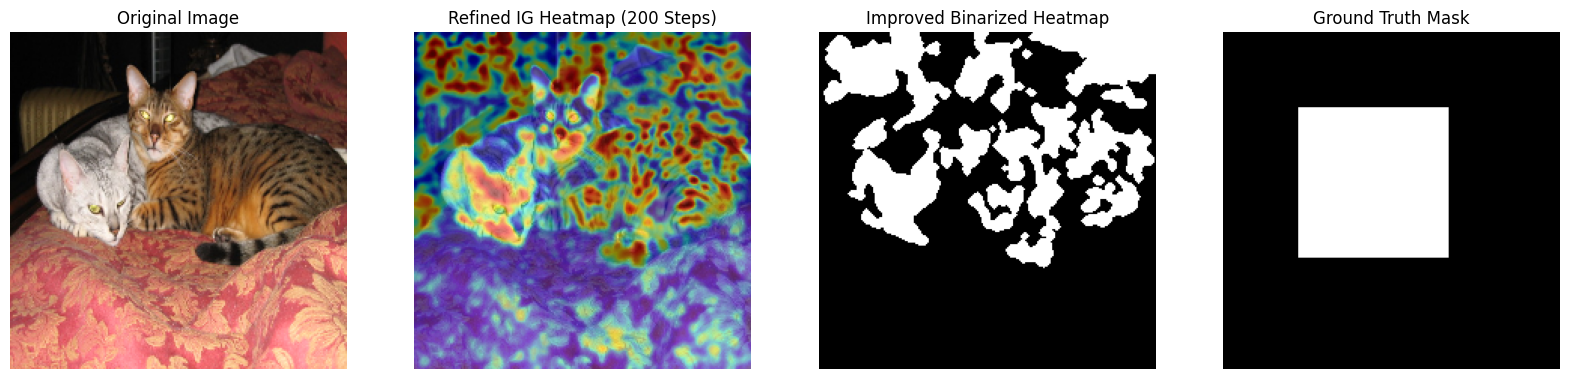

In [ ]:
def preprocess_image(image_path):
    """Loads and preprocesses an image for DenseNet-121."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def compute_ig_metrics(ig_heatmap, ground_truth_mask, original_probs, masked_probs):
    """
    Computes evaluation metrics for IG explanations with **optimized binarization & noise filtering**.
    """

    # Normalize & apply refined smoothing (Adaptive σ=2.5)
    ig_heatmap = (ig_heatmap - ig_heatmap.min()) / (ig_heatmap.max() - ig_heatmap.min())
    ig_heatmap = gaussian_filter(ig_heatmap, sigma=2.5)  #  Slightly lower than 3 for more structure

    # Adaptive thresholding with fine-tuned Otsu’s method
    thresh = threshold_otsu(ig_heatmap) * 1.05  # Lower multiplier for **less strict filtering**
    binarized_heatmap = (ig_heatmap >= thresh).astype(np.uint8)

    # Morphological filtering (Better noise cleanup)
    binarized_heatmap = remove_small_objects(binarized_heatmap.astype(bool), min_size=500).astype(np.uint8)
    binarized_heatmap = remove_small_holes(binarized_heatmap.astype(bool), area_threshold=500).astype(np.uint8)

    # **Erosion & Dilation for fine-tuning**
    binarized_heatmap = erosion(binarized_heatmap, disk(2))  # Remove **tiny specks**
    binarized_heatmap = dilation(binarized_heatmap, disk(2))  # Recover **edges of valid activations**

    # Compute True Positives, False Positives, False Negatives
    intersection = np.logical_and(binarized_heatmap, ground_truth_mask).sum()
    union = np.logical_or(binarized_heatmap, ground_truth_mask).sum()
    false_positives = (binarized_heatmap == 1).sum() - intersection
    false_negatives = (ground_truth_mask == 1).sum() - intersection

    # Compute Metrics
    iou = intersection / union if union != 0 else 0
    precision = intersection / (intersection + false_positives) if (intersection + false_positives) > 0 else float('nan')
    recall = intersection / (intersection + false_negatives) if (intersection + false_negatives) > 0 else float('nan')

    # Pointing Game: Does the max activation fall inside the ground truth region?
    max_activation_point = np.unravel_index(np.argmax(ig_heatmap), ig_heatmap.shape)
    pointing_game_score = int(ground_truth_mask[max_activation_point] == 1)

    # Compute Average Drop and Confidence Increase
    avg_drop = ((original_probs - masked_probs) / original_probs) * 100 if original_probs > 0 else 0
    confidence_increase = ((masked_probs - original_probs) / original_probs) * 100 if original_probs > 0 else 0

    return {
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "Pointing Game": pointing_game_score,
        "Average Drop (%)": avg_drop,
        "Increase in Confidence (%)": confidence_increase
    }


def visualize_ig_evaluation(image, ig_heatmap, ground_truth_mask):
    """
    Displays the original image, IG heatmap, **improved** binarized heatmap, and ground truth mask.
    """

    # Normalize IG heatmap
    ig_heatmap = (ig_heatmap - ig_heatmap.min()) / (ig_heatmap.max() - ig_heatmap.min())

    # Adaptive thresholding with fine-tuned Otsu’s method
    thresh = threshold_otsu(ig_heatmap) * 1.05
    binarized_heatmap = (ig_heatmap >= thresh).astype(np.uint8)

    # Morphological filtering
    binarized_heatmap = remove_small_objects(binarized_heatmap.astype(bool), min_size=500).astype(np.uint8)
    binarized_heatmap = remove_small_holes(binarized_heatmap.astype(bool), area_threshold=500).astype(np.uint8)
    binarized_heatmap = erosion(binarized_heatmap, disk(2))
    binarized_heatmap = dilation(binarized_heatmap, disk(2))

    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # IG Heatmap
    axes[1].imshow(image)
    axes[1].imshow(ig_heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title("Refined IG Heatmap (200 Steps)")
    axes[1].axis("off")

    # Improved Binarized Heatmap
    axes[2].imshow(binarized_heatmap, cmap="gray")
    axes[2].set_title("Improved Binarized Heatmap")
    axes[2].axis("off")

    # Ground Truth Mask
    axes[3].imshow(ground_truth_mask, cmap="gray")
    axes[3].set_title("Ground Truth Mask")
    axes[3].axis("off")

    plt.show()


def faithfulness_deletion(model, image, attributions, target_class):
    """ Removes **top 10% important regions** and checks confidence drop. """
    mask = attributions > np.percentile(attributions, 90)
    mask = np.expand_dims(mask, axis=(0, 1))  
    mask = np.repeat(mask, 3, axis=1)  # Fix shape issue

    masked_image = image.clone()
    masked_image[mask] = 0  # Ensure only top 10% are blacked out

    with torch.no_grad():
        output = model(masked_image)
    return output[0, target_class].item()
# Load your real image
image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"

# Load and preprocess image
image_tensor = preprocess_image(image_path)

# Load original image for visualization
orig_image = cv2.imread(image_path)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
orig_image = cv2.resize(orig_image, (224, 224))

# Generate Integrated Gradients attributions (200 Steps)
output = model(image_tensor)
predicted_class = torch.argmax(output).item()
ig_heatmap = integrated_gradients(model, image_tensor, predicted_class, steps=200)  # **Limited to 200 Steps**

# Example Ground Truth Mask 
ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[50:150, 50:150] = 1 

# Compute refined evaluation metrics
original_probs = output[0, predicted_class].item()
masked_probs = faithfulness_deletion(model, image_tensor, ig_heatmap, predicted_class)

metrics = compute_ig_metrics(ig_heatmap, ground_truth_mask, original_probs, masked_probs)
print(" **Optimized Evaluation Metrics (200 Steps IG):**", metrics)

# Visualize results
visualize_ig_evaluation(orig_image, ig_heatmap, ground_truth_mask)


## **TCAV Implementation with Integrated Gradients**

### **1. Feature Extraction for Concept Activation**
- The function `extract_ig_activations()`:
  - Runs **Integrated Gradients (IG)** on each concept dataset.
  - Extracts activations from the model to be used for TCAV training.
  - Activations are **normalized** across the dataset to standardize values.

- The IG activations for an input image $ x $ with respect to a target class $ y $ are computed as:

$$
IG_i(x) = (x_i - x'_i) \times \sum_{k=1}^{N} \frac{\partial f(x' + \frac{k}{N} (x - x'))}{\partial x_i} \times \frac{1}{N}
$$

where:
- $ x' $ is the **baseline image** (typically black).
- $ \alpha $ is the **scaling factor** interpolating between the baseline and input.
- $ f(x) $ is the **model's output score** for class $ y $.
- $ N $ is the **number of integration steps**.

### **2. Training Concept Activation Vectors (CAVs)**
- The function `train_cav()`:
  - Uses **logistic regression** to learn **Concept Activation Vectors (CAVs)**.
  - CAVs are trained to differentiate between:
    - **Stripes vs. Random**
    - **Fur vs. Random**
    - **Face Shape vs. Random**

- Given a dataset of concept activations $ X $ and labels $ Y $, a **logistic regression model** is trained:

$$
\hat{y} = \sigma(WX + b)
$$

where:
- $ W $ is the **learned weight vector**, forming the **Concept Activation Vector (CAV)**.
- $ \sigma $ is the **sigmoid function** ensuring binary classification.
- The **CAV vector** is extracted from $ W $ after training.

### **3. Computing TCAV Scores**
- `compute_tcav_score()` evaluates **how much a model relies on a concept**.
- It does so by measuring the **directional derivative** of the model’s prediction along the CAV:

$$
TCAV(C,y) = \frac{1}{|X|} \sum_{x \in X} \mathbb{1} \left[ \frac{d f_y}{d v_{C}} > 0 \right]
$$

where:
- $ v_{C} $ is the **CAV for concept $ C $**.
- $ \frac{d f_y}{d v_{C}} $ is the **directional derivative** along $ v_{C} $, measuring how model confidence changes when shifting in the concept’s direction.
- $ \mathbb{1} $ is an **indicator function**, counting cases where this derivative is **positive**.
- A **high TCAV score** means the model **relies on the concept** when making a prediction.

### **4. Interpreting TCAV Scores**
- **Higher TCAV scores** suggest that a concept plays a **key role** in a model’s decision.
- **Lower scores** indicate **low relevance** of the concept to the model’s decision.


In [ ]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load DenseNet-121 Model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)
model.eval()

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to Load Images from Folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.endswith(('.png', '.jpg', '.jpeg')):  
            try:
                image = Image.open(img_path).convert("RGB")  
                image = transform(image).to(device)  
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return torch.stack(images) if images else None

# Load Concept Images (Stripes, Fur, Face Shape, Random)
concepts = {
    "Stripes": load_images_from_folder("concepts/stripes"),
    "Fur": load_images_from_folder("concepts/fur_texture"),
    "Face Shape": load_images_from_folder("concepts/face_shape"),
    "Random": load_images_from_folder("concepts/random_baseline")
}

# Print Dataset Sizes
for concept, images in concepts.items():
    print(f"{concept}: {len(images)} images")

# Integrated Gradients Function (With Smoothing)
def integrated_gradients(model, image, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(image)  # Black baseline

    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(device)
    interpolated_images = baseline + alphas * (image - baseline)
    interpolated_images.requires_grad_()

    output = model(interpolated_images)
    loss = output[:, target_class].sum()

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated_images, retain_graph=False)[0]
    avg_gradients = gradients.mean(dim=0)  # Average gradients

    # Compute IG Attributions with Smoothing
    attributions = (image - baseline) * avg_gradients
    attributions = attributions.squeeze().detach().cpu().numpy().sum(axis=0)

    # Apply Gaussian Smoothing
    attributions = gaussian_filter(attributions, sigma=3)

    return attributions

# Extract IG Activations for CAV Training
def extract_ig_activations(images, model):
    activations = []
    for image in images:
        image = image.unsqueeze(0).to(device)
        output = model(image)
        predicted_class = torch.argmax(output).item()
        attributions = integrated_gradients(model, image, predicted_class, steps=50)
        activations.append(attributions.flatten())  # Flatten for CAV training
    return np.array(activations)  # Convert to NumPy array for compatibility

# Compute IG activations for all concepts
ig_activations = {concept: extract_ig_activations(images, model) for concept, images in concepts.items()}

# Normalize Activations
def normalize_activations(activations):
    return (activations - activations.mean(axis=0)) / (activations.std(axis=0) + 1e-8)

for concept in ["Stripes", "Fur", "Face Shape", "Random"]:
    ig_activations[concept] = normalize_activations(ig_activations[concept])

# Train Concept Activation Vectors (CAVs)
def train_cav(concept_activations, random_activations):
    X = np.concatenate([concept_activations, random_activations], axis=0)
    Y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

    cav = LogisticRegression(C=10.0, max_iter=5000, solver="lbfgs")
    cav.fit(X, Y)

    return cav.coef_[0]  # Concept Activation Vector

# Train CAVs for all three concepts
cavs = {concept: train_cav(ig_activations[concept], ig_activations["Random"]) for concept in ["Stripes", "Fur", "Face Shape"]}

# Compute TCAV Score
def compute_tcav_score(image_activations, cav_vector):
    image_activations = np.array(image_activations)
    cav_vector = np.array(cav_vector)

    image_activations /= (np.linalg.norm(image_activations, axis=1, keepdims=True) + 1e-8)
    cav_vector /= (np.linalg.norm(cav_vector) + 1e-8)

    directional_derivative = np.dot(image_activations, cav_vector)

    # Debug Information
    mean_dd = directional_derivative.mean()
    std_dd = directional_derivative.std()
    print(f"Mean DD: {mean_dd:.4f}, Std DD: {std_dd:.4f}")

    return float(np.mean(directional_derivative > 0))

# Load Image for TCAV
image_path = "TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
image_activations = integrated_gradients(model, image_tensor, torch.argmax(model(image_tensor)).item(), steps=50).reshape(1, -1)

# Compute TCAV Scores for All Concepts
tcav_scores = {}
for concept in ["Stripes", "Fur", "Face Shape"]:
    tcav_score = compute_tcav_score(image_activations, cavs[concept])
    tcav_scores[concept] = tcav_score
    print(f"TCAV Score for '{concept}' Concept: {tcav_score:.4f}")

# Display Activation Shapes and Mean Activation Stats
for concept, activations in ig_activations.items():
    mean_activation = activations.mean()
    std_activation = activations.std()
    print(f"{concept} Activation Shape: {activations.shape}")
    print(f"Mean Activation ({concept}): {mean_activation:.10f} ± {std_activation:.10f}")


Stripes: 86 images
Fur: 107 images
Face Shape: 143 images
Random: 93 images
Mean DD: 0.0053, Std DD: 0.0000
TCAV Score for 'Stripes' Concept: 1.0000
Mean DD: 0.0031, Std DD: 0.0000
TCAV Score for 'Fur' Concept: 1.0000
Mean DD: 0.0103, Std DD: 0.0000
TCAV Score for 'Face Shape' Concept: 1.0000
Stripes Activation Shape: (86, 50176)
Mean Activation (Stripes): -0.0000000002 ± 0.9999986291
Fur Activation Shape: (107, 50176)
Mean Activation (Fur): 0.0000000002 ± 0.9999987483
Face Shape Activation Shape: (143, 50176)
Mean Activation (Face Shape): 0.0000000002 ± 0.9999990463
Random Activation Shape: (93, 50176)
Mean Activation (Random): 0.0000000004 ± 0.9999986887
